# hyper parameter tunning
- hyper-parameter는 추정기(model)의 내부의 직접적인 모수가 아니다.
- hyper-parameter는추정기 클래스 생성자의 argument로 전달 된다. 
   - support vector classifier의 C, kernel, gamma, degree
   - decision Tree classifier의 max_depth, min_samples_split, min_samples_leaf 등 이 있다. 
- best cv score를 위해 hyper-parameter space를 서치하는 것이 권장된다.
- 추정기에 사용 된 hyper-parameter 찾기
   - estimator.get_params()
- 아래와 같은 방법으로 search
   - 추정기 (estimator)
   - 모수 공간 (parameter space)
   - 후보자 샘플링, 검색 방법
   - 교차 검증 방식과 점수 함수
- scikit-learn의 모수 검색 방법 2가지 
   - GridSearchCV : 모든 매개변수의 조합을 고려하는 CV
   - RandomizedSearchCV : 구체적인 분포(dist)를 사용하여 매개변수 공간의 후보들을 샘플링하는 CV
   - HalvingGridSearchCV, HalvingRandomSearchCV : GSCV와, RSCV를 보완하는 빠른 CV
- 모델의 예측에 크게 영향을 끼치는 parameter 들을 search 할때, 다른 paramter는 기본값으로 설정하는 것이 일반적이다.
   - 추정기의 docstring 을 참고하여 추정기의 hyper-parameter 들에 대해서 알 수 있다.
- 참고
   - https://scikit-learn.org/stable/modules/grid_search.html#grid-search

## 철저한 Grid Search

In [17]:
gscv_param_grid = [
    {"C": [10 ** c for c in range(4)], "kernel": ["linear"]},
    {"C": [10 ** c for c in range(4)], "gamma": [0.001, 0.0001], "kernel": ["rbf"]}
]

gscv_param_grid

[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
 {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

## RandomizedSearchCV

In [16]:
rscv_param_grid = {
    "C": sp.stats.expon(scale=100), 
    "gamma": sp.stats.expon(scale=1),
    "kernel": ["rbf"],
    "class_weight": ["balanced", None]
             }
rscv_param_grid

{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d2b5b29ba0>,
 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d2b4aacbe0>,
 'kernel': ['rbf'],
 'class_weight': ['balanced', None]}

### loguniform 함수
- 로그 균일 샘플 생성 확률변수
   - [1, 10, 100, 1000]의 값을 생성 할 수 있다.

In [25]:
from scipy.stats import loguniform

In [32]:
rscv_param_grid = {
    "C": loguniform(1e0, 1e3),
    "gamma": loguniform(1e-4, 1e-3),
    "kernel": ["rbf"],
    "class_weight": ["balnaced", None]
}

rscv_param_grid

{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d2b69538e0>,
 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d2b69533d0>,
 'kernel': ['rbf'],
 'class_weight': ['balnaced', None]}

## compare Randomized Search cv and Grid Search cv
- RSCV와 GSCV를 사용하여 SGD 훈련을 통해 linear SVM의 하이퍼 파라미터를 최적화하고 비교한다.
- 동일한 매개변수 공간을 사용
- RSCV가 더 빠르다는 것을 확인 할 수 있다.
- RSCV는 성능이 저해될 수 있으며 노이즈로 인해 held-out test set로 이어지지 않는 것으로 보인다.

In [1]:
from sklearn.datasets import load_digits

In [2]:
X, y = load_digits(return_X_y=True)

X.shape, y.shape

((1797, 64), (1797,))

In [3]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))

In [4]:
from sklearn.linear_model import SGDClassifier

In [5]:
clf = SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)
clf

SGDClassifier(penalty='elasticnet')

### best score를 반환하는 Utility function

In [25]:
from scipy import stats

In [37]:
def reports(results, n_top=3) : 
    
    for i in range(1, n_top + 1) : 
        # candidates = i rank에 해당하는 인덱스 (같은 순위가 여러개일 수도 있다.)
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates : 
            print("Model with rank : {0}".format(i))
            print("Mean validation score : {0:.3f} (std : {1:.3f})".format(
                        results["mean_test_score"][candidate], 
                        results["std_test_score"][candidate])
                 )
            print("Parameters : {0}".format(results["params"][candidate]))
            print("")

In [38]:
test = np.array([1, 2, 3, 4, 5])
test >= 3

array([False, False,  True,  True,  True])

In [18]:
# T에 해당하는 요소의 인덱스를 array로 반환

np.flatnonzero(test >= 3)

array([2, 3, 4], dtype=int64)

In [19]:
# T에 해당하는 요소의 인덱스 array를 tuple로 담아서 반환

np.nonzero(test >= 3)

(array([2, 3, 4], dtype=int64),)

### Run RSCV

In [27]:
param_dist = {
    "average": [True, False],
    "l1_ratio": stats.uniform(0, 1),
    "alpha": stats.loguniform(1e-2, 1e0)
}

param_dist

{'average': [True, False],
 'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x14e9622b070>,
 'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x14e9601ead0>}

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

In [32]:
n_iter_search = 15
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time.time()
random_search.fit(X, y)

print("RSCV took %.2f seconds for %d candidates parameter settings."
     % ((time.time() - start), n_iter_search))

RSCV took 14.33 seconds for 15 candidates parameter settings.


In [39]:
reports(random_search.cv_results_)

Model with rank : 1
Mean validation score : 0.917 (std : 0.019)
Parameters : {'alpha': 0.07215852490251935, 'average': False, 'l1_ratio': 0.436535809693109}

Model with rank : 2
Mean validation score : 0.915 (std : 0.032)
Parameters : {'alpha': 0.05033032208653747, 'average': False, 'l1_ratio': 0.2939919549781841}

Model with rank : 3
Mean validation score : 0.908 (std : 0.028)
Parameters : {'alpha': 0.05250219609051528, 'average': False, 'l1_ratio': 0.4363325162846925}



In [48]:
np.flatnonzero(random_search.cv_results_["rank_test_score"] == 10)

array([13], dtype=int64)

In [59]:
rscv_result_df = pd.DataFrame(random_search.cv_results_).sort_values(
                    "rank_test_score")
rscv_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_average,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.062799,0.007382,0.001000,0.000007,0.072159,False,0.436536,"{'alpha': 0.07215852490251935, 'average': Fals...",0.922222,0.905556,0.913649,0.949861,0.894150,0.917088,0.018822,1
6,0.096197,0.009682,0.001003,0.000001,0.05033,False,0.293992,"{'alpha': 0.05033032208653747, 'average': Fals...",0.916667,0.863889,0.933148,0.961003,0.902507,0.915443,0.032298,2
0,0.066207,0.010590,0.009728,0.017450,0.052502,False,0.436333,"{'alpha': 0.05250219609051528, 'average': Fals...",0.908333,0.880556,0.924791,0.949861,0.874652,0.907639,0.027925,3
14,0.070411,0.016009,0.000992,0.000012,0.443409,False,0.184678,"{'alpha': 0.4434092657866859, 'average': False...",0.922222,0.886111,0.902507,0.955432,0.866295,0.906513,0.030625,4
5,0.337595,0.029981,0.000809,0.000405,0.017942,False,0.772576,"{'alpha': 0.017942076515330467, 'average': Fal...",0.916667,0.841667,0.919220,0.955432,0.880223,0.902642,0.038675,5
4,1.000545,0.091318,0.000995,0.000019,0.028976,False,0.986149,"{'alpha': 0.028976446360621227, 'average': Fal...",0.908333,0.794444,0.916435,0.919220,0.849582,0.877603,0.048754,6
12,0.057200,0.013616,0.001002,0.000002,0.405318,False,0.636182,"{'alpha': 0.4053176862040591, 'average': False...",0.780556,0.741667,0.802228,0.824513,0.760446,0.781882,0.029359,7
10,0.444642,0.055814,0.000989,0.000016,0.256024,False,0.948151,"{'alpha': 0.2560243572932588, 'average': False...",0.783333,0.547222,0.768802,0.693593,0.674095,0.693409,0.084278,8
2,0.038205,0.003699,0.000794,0.000397,0.804575,False,0.61351,"{'alpha': 0.8045750010680005, 'average': False...",0.591667,0.588889,0.746518,0.557103,0.548747,0.606585,0.071987,9
13,0.175697,0.018313,0.001002,0.000633,0.013754,True,0.548291,"{'alpha': 0.013753529289497458, 'average': Tru...",0.652778,0.450000,0.437326,0.629526,0.484680,0.530862,0.091672,10


### RSCV의 매개변수 공간

In [94]:
alphas = rscv_result_df["params"].apply(lambda x : x["alpha"].round(3))
averages = rscv_result_df["params"].apply(lambda x : x["average"])
l1_ratios = rscv_result_df["params"].apply(lambda x : x["l1_ratio"].round(3))
pd.DataFrame({"alpha": alphas, "average": averages, "l1_ratio": l1_ratios},
            columns=["alpha", "average", "l1_ratio"])

,alpha,average,l1_ratio
11,0.072,False,0.437
6,0.050,False,0.294
0,0.053,False,0.436
14,0.443,False,0.185
5,0.018,False,0.773
4,0.029,False,0.986
12,0.405,False,0.636
10,0.256,False,0.948
2,0.805,False,0.614
13,0.014,True,0.548


In [96]:
random_search.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(estimator=SGDClassifier(penalty='elasticnet'), n_iter=15,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014E9601EAD0>,
                                        'average': [True, False],
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000014E9622B070>})>

### Run GSCV 

In [51]:
param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float))
}

param_grid

{'average': [True, False],
 'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 'alpha': array([0.01, 0.1 , 1.  ])}

#### np.power() 배열의 요소를 설정한 값으로 제곱수하여 반환
- np.power(x1, x2)
- x1의 배열의 요소에 x2의 값 만큼 제곱수를 반환

In [52]:
np.power(10, np.arange(-2, 1, dtype=float))

array([0.01, 0.1 , 1.  ])

In [54]:
# x1의 모든 요소를 3제곱하여 반환

x1 = np.array([1, 2, 3, 4, 5])
np.power(x1, 3)

array([  1,   8,  27,  64, 125], dtype=int32)

In [56]:
# x1의 요소에 해당하는 인덱스의 x2 값만큼 제곱하여 반환

x2 = np.array([1, 2, 3, 2, 1])
np.power(x1, x2)

array([ 1,  4, 27, 16,  5])

In [58]:
# 브로드캐스팅 기능 : 행렬의 각 요소도 같은 인덱스의 값에 맞는 제곱수 반환

x1 = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
x2 = np.array([[1, 2, 2, 2, 1], [1, 3, 3, 3, 1]])

np.power(x1, x2)

array([[ 1,  4,  9, 16,  5],
       [ 1,  8, 27, 64,  5]])

In [97]:
grid_search = GridSearchCV(clf, param_grid=param_grid)

start = time.time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
     % ((time.time() - start), len(grid_search.cv_results_["params"])))

GridSearchCV took 68.23 seconds for 60 candidate parameter settings.


In [98]:
reports(grid_search.cv_results_)

Model with rank : 1
Mean validation score : 0.927 (std : 0.028)
Parameters : {'alpha': 1.0, 'average': False, 'l1_ratio': 0.0}

Model with rank : 2
Mean validation score : 0.926 (std : 0.023)
Parameters : {'alpha': 0.1, 'average': True, 'l1_ratio': 0.0}

Model with rank : 3
Mean validation score : 0.922 (std : 0.033)
Parameters : {'alpha': 1.0, 'average': True, 'l1_ratio': 0.0}



### RSCV와 GSCV의 rank 1, 2, 3 비교
- RSCV가 GSCV 보다 매개변수 공간의 샘플이 더 많으나, 훈련 시간 등 훈련 비용이 더 적게 든다는게 일반적
- 그러나 성능은 RSCV보다 GSCV가 더 높은편

In [100]:
print("RSCV took %.2f seconds for %d candidates parameter settings."
     % ((time.time() - start), n_iter_search))
reports(random_search.cv_results_)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
     % ((time.time() - start), len(grid_search.cv_results_["params"])))
reports(grid_search.cv_results_)

RSCV took 4016.08 seconds for 15 candidates parameter settings.
Model with rank : 1
Mean validation score : 0.917 (std : 0.019)
Parameters : {'alpha': 0.07215852490251935, 'average': False, 'l1_ratio': 0.436535809693109}

Model with rank : 2
Mean validation score : 0.915 (std : 0.032)
Parameters : {'alpha': 0.05033032208653747, 'average': False, 'l1_ratio': 0.2939919549781841}

Model with rank : 3
Mean validation score : 0.908 (std : 0.028)
Parameters : {'alpha': 0.05250219609051528, 'average': False, 'l1_ratio': 0.4363325162846925}

GridSearchCV took 4016.08 seconds for 60 candidate parameter settings.
Model with rank : 1
Mean validation score : 0.927 (std : 0.028)
Parameters : {'alpha': 1.0, 'average': False, 'l1_ratio': 0.0}

Model with rank : 2
Mean validation score : 0.926 (std : 0.023)
Parameters : {'alpha': 0.1, 'average': True, 'l1_ratio': 0.0}

Model with rank : 3
Mean validation score : 0.922 (std : 0.033)
Parameters : {'alpha': 1.0, 'average': True, 'l1_ratio': 0.0}



### RSCV와 GSCV의 parameter의 샘플 비교

In [109]:
gscv_result_df = pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
gscv_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_average,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
50,0.076195,0.013495,0.000800,4.002102e-04,1.0,False,0.0,"{'alpha': 1.0, 'average': False, 'l1_ratio': 0.0}",0.938889,0.916667,0.941504,0.958217,0.877437,0.926543,0.027887,1
20,0.112397,0.016045,0.001002,8.120244e-07,0.1,True,0.0,"{'alpha': 0.1, 'average': True, 'l1_ratio': 0.0}",0.916667,0.902778,0.963788,0.941504,0.905292,0.926006,0.023339,2
40,0.079397,0.007397,0.000802,4.009069e-04,1.0,True,0.0,"{'alpha': 1.0, 'average': True, 'l1_ratio': 0.0}",0.930556,0.902778,0.941504,0.966574,0.869081,0.922098,0.033497,3
0,0.138197,0.028293,0.000796,3.979095e-04,0.01,True,0.0,"{'alpha': 0.01, 'average': True, 'l1_ratio': 0.0}",0.911111,0.886111,0.944290,0.966574,0.899721,0.921561,0.029616,4
31,0.080198,0.010648,0.000601,4.909528e-04,0.1,False,0.111111,"{'alpha': 0.1, 'average': False, 'l1_ratio': 0...",0.913889,0.897222,0.947075,0.947075,0.902507,0.921554,0.021523,5
10,0.116007,0.016364,0.000994,1.337441e-05,0.01,False,0.0,"{'alpha': 0.01, 'average': False, 'l1_ratio': ...",0.922222,0.891667,0.927577,0.947075,0.916435,0.920995,0.017922,6
30,0.092799,0.005638,0.000804,4.022908e-04,0.1,False,0.0,"{'alpha': 0.1, 'average': False, 'l1_ratio': 0.0}",0.897222,0.880556,0.935933,0.969359,0.905292,0.917673,0.031477,7
32,0.081599,0.015597,0.000800,4.001626e-04,0.1,False,0.222222,"{'alpha': 0.1, 'average': False, 'l1_ratio': 0...",0.933333,0.891667,0.938719,0.941504,0.880223,0.917089,0.025819,8
12,0.112016,0.010351,0.000986,1.847189e-05,0.01,False,0.222222,"{'alpha': 0.01, 'average': False, 'l1_ratio': ...",0.919444,0.858333,0.949861,0.966574,0.888579,0.916558,0.039476,9
13,0.106798,0.012074,0.001002,1.293627e-06,0.01,False,0.333333,"{'alpha': 0.01, 'average': False, 'l1_ratio': ...",0.908333,0.886111,0.955432,0.933148,0.896936,0.915992,0.025157,10


In [117]:
print("== GSCV의 hyper-parameter alpha sample : ==\n ", np.unique(
    gscv_result_df["params"].apply(lambda x : x["alpha"])))
print("== RSCV의 hyper-parameter alpha sample : ==\n ", np.unique(
    rscv_result_df["params"].apply(lambda x : x["alpha"])))

== GSCV의 hyper-parameter alpha sample : ==
  [0.01 0.1  1.  ]
== RSCV의 hyper-parameter alpha sample : ==
  [0.01191219 0.01375353 0.01794208 0.02897645 0.03732162 0.05033032
 0.05062306 0.0525022  0.07215852 0.25602436 0.40531769 0.44340927
 0.56164054 0.76230309 0.804575  ]


In [118]:
print("== GSCV의 hyper-parameter l1_ratio sample : ==\n ", np.unique(
    gscv_result_df["params"].apply(lambda x : x["l1_ratio"])))
print("== RSCV의 hyper-parameter l1_ratio sample : ==\n ", np.unique(
    rscv_result_df["params"].apply(lambda x : x["l1_ratio"])))

== GSCV의 hyper-parameter l1_ratio sample : ==
  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
== RSCV의 hyper-parameter l1_ratio sample : ==
  [0.0246953  0.18467753 0.26918882 0.29399195 0.34618346 0.37933523
 0.43633252 0.43653581 0.5482909  0.61350974 0.63618179 0.63688259
 0.77257649 0.94815132 0.9861485 ]


## Successive Halving Iterations
- 연속 반감기 CV 테스트
- HalvingGridSearchCV, HalvingRandomSearchCV
- HRSCV의 속성값
   - n_interations_ : 실험 반복 횟수
   - n_candidates_ : 실험 별 후보자 수 (params 조합)
   - n_resources_ : 실험 별 데이터 샘플의 수
- 실험별 데이터 샘플의 수가 2배 늘어나고, 가장 좋은 성능 절반만 다음 실험에 사용됨
   - 적은 모델이 더 많은 샘플로 훈련하게 된다.
- 최종 2개의 후보만 남는다.

In [121]:
from sklearn.datasets import make_classification

In [123]:
rng = np.random.RandomState(0)

X, y = make_classification(n_samples=400, n_features=12, random_state=rng)

X.shape, y.shape

((400, 12), (400,))

In [124]:
X[0]

array([ 1.50875857,  0.21973688, -0.53633252,  0.5369391 , -0.27387268,
       -0.59115967,  0.36800366,  0.15706946, -0.98045925, -0.56776724,
       -0.14517024,  1.08259137])

In [125]:
np.unique(y, return_counts=True)

(array([0, 1]), array([199, 201], dtype=int64))

In [127]:
from sklearn.ensemble import RandomForestClassifier
# HalvingCV는 experimetal 패키지의 모듈을 함께 사용해야함
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [144]:
rng

RandomState(MT19937) at 0x14E9CF42740

In [151]:
rf_clf = RandomForestClassifier(n_estimators=20, random_state=rng)
param_grid = {
    "max_depth": [3, None],
    "max_features": stats.randint(1, 6), # 1~6 의 램덤 정수 선택
    "min_samples_split": stats.randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

start = time.time()

h_rscv = HalvingRandomSearchCV(
    estimator=rf_clf, param_distributions=param_grid, factor=2, random_state=rng
)
h_rscv.fit(X, y)

HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=RandomState(MT19937) at 0x14E9CF42740),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000014E9D2145B0>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000014E9E482920>},
                      random_state=RandomState(MT19937) at 0x14E9CF42740)

In [147]:
print("Halving RSCV fitting time : ", time.time() - start)

reports(h_rscv.cv_results_)

Model with rank : 1
Mean validation score : 0.909 (std : 0.027)
Parameters : {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_split': 8}

Model with rank : 2
Mean validation score : 0.900 (std : 0.050)
Parameters : {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_split': 7}

Model with rank : 2
Mean validation score : 0.900 (std : 0.050)
Parameters : {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_split': 8}

Model with rank : 2
Mean validation score : 0.900 (std : 0.050)
Parameters : {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_split': 10}

Model with rank : 2
Mean validation score : 0.900 (std : 0.050)
Parameters : {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 3}



In [148]:
h_rscv.get_params

<bound method BaseEstimator.get_params of HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=RandomState(MT19937) at 0x14E9CF42740),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000014E9D0D97E0>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000014E9E3AE530>},
                      random_state=RandomState(MT19937) at 0x14E9CF42740)>

In [153]:
h_rscv_result_df = pd.DataFrame(h_rscv.cv_results_).sort_values("rank_test_score")
h_rscv_result_df

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
17,0,20,0.022000,0.001095,0.002200,4.000902e-04,True,gini,None,4,...,0.950000,0.100000,1,1.000000,1.000000,1.000000,1.000000,0.937500,0.987500,0.025000
38,4,320,0.032801,0.000392,0.002197,4.013805e-04,True,gini,3,5,...,0.903125,0.038780,2,0.929688,0.945312,0.925781,0.929688,0.929688,0.932031,0.006811
1,0,20,0.021592,0.001024,0.002006,1.195274e-05,True,entropy,None,4,...,0.900000,0.200000,3,0.937500,0.937500,1.000000,1.000000,0.875000,0.950000,0.046771
15,0,20,0.022800,0.001469,0.002599,4.893789e-04,True,entropy,None,4,...,0.900000,0.200000,3,1.000000,0.937500,1.000000,1.000000,0.937500,0.975000,0.030619
39,4,320,0.039206,0.000752,0.002191,4.047727e-04,True,gini,None,5,...,0.893750,0.018222,5,0.996094,1.000000,0.996094,0.996094,1.000000,0.997656,0.001914
37,3,160,0.028599,0.000800,0.002400,8.002303e-04,True,gini,None,5,...,0.881250,0.036443,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25,1,40,0.021201,0.000399,0.002198,4.006639e-04,True,entropy,3,4,...,0.875000,0.111803,7,0.968750,1.000000,0.968750,1.000000,0.968750,0.981250,0.015309
26,1,40,0.020801,0.000400,0.002002,1.647678e-06,True,gini,3,5,...,0.875000,0.111803,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
32,2,80,0.024204,0.000399,0.002195,4.007946e-04,True,gini,None,5,...,0.875000,0.068465,7,1.000000,1.000000,1.000000,1.000000,0.984375,0.996875,0.006250
24,1,40,0.022000,0.000633,0.002000,1.393475e-06,True,gini,None,5,...,0.875000,0.111803,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [157]:
h_rscv_result_df.filter(regex="^(param_|rank)")

,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_split,rank_test_score
17,True,gini,None,4,5,1
38,True,gini,3,5,4,2
1,True,entropy,None,4,7,3
15,True,entropy,None,4,5,3
39,True,gini,None,5,2,5
37,True,gini,None,5,2,6
25,True,entropy,3,4,4,7
26,True,gini,3,5,4,7
32,True,gini,None,5,2,7
24,True,gini,None,5,2,7


### plot model evaluate

In [160]:
h_rscv_result_df["params_str"] = h_rscv_result_df.params.apply(str)
h_rscv_result_df["params_str"]

17    {'bootstrap': True, 'criterion': 'gini', 'max_...
38    {'bootstrap': True, 'criterion': 'gini', 'max_...
1     {'bootstrap': True, 'criterion': 'entropy', 'm...
15    {'bootstrap': True, 'criterion': 'entropy', 'm...
39    {'bootstrap': True, 'criterion': 'gini', 'max_...
37    {'bootstrap': True, 'criterion': 'gini', 'max_...
25    {'bootstrap': True, 'criterion': 'entropy', 'm...
26    {'bootstrap': True, 'criterion': 'gini', 'max_...
32    {'bootstrap': True, 'criterion': 'gini', 'max_...
24    {'bootstrap': True, 'criterion': 'gini', 'max_...
36    {'bootstrap': True, 'criterion': 'gini', 'max_...
34    {'bootstrap': True, 'criterion': 'gini', 'max_...
35    {'bootstrap': True, 'criterion': 'gini', 'max_...
8     {'bootstrap': True, 'criterion': 'entropy', 'm...
29    {'bootstrap': True, 'criterion': 'gini', 'max_...
28    {'bootstrap': True, 'criterion': 'entropy', 'm...
7     {'bootstrap': True, 'criterion': 'gini', 'max_...
27    {'bootstrap': True, 'criterion': 'entropy'

In [164]:
# 반복 시행별 parameter 조합의 갯수

h_rscv_result_df[["params_str", "iter"]].groupby("iter").count()

,params_str
iter,
0,20
1,10
2,5
3,3
4,2


In [165]:
# params_str과 iter가 중복인 행 제거

h_rscv_result_df.drop_duplicates(subset=("params_str", "iter"), inplace=True)

In [166]:
h_rscv_result_df[["params_str", "iter"]].groupby("iter").count()

,params_str
iter,
0,19
1,10
2,5
3,3
4,2


In [167]:
# pivot을 사용하여, iter 별 params_str의 점수 검색
# 이전 실험에서 성능이 좋은 params만 다음 실험에서 재차 실험된다.

mean_scores = h_rscv_result_df.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
mean_scores

params_str,"{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_split': 5}","{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_split': 2}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_split': 8}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 6}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 7}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_split': 5}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 4}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_split': 3}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_split': 10}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_split': 5}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_split': 8}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_split': 5}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_split': 7}","{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_split': 7}","{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_split': 8}","{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_split': 4}","{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 4}","{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_split': 5}","{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_split': 2}"
iter,,,,,,,,,,,,,,,,,,,
0,0.80,0.75,0.75,0.800,0.75,0.80,0.850,0.75,0.65,0.7,0.800,0.90,0.9000,0.75,0.75,0.850000,0.75,0.9500,0.85000
1,0.85,NaN,NaN,0.825,NaN,0.85,0.875,NaN,NaN,NaN,0.725,0.85,0.8500,NaN,NaN,0.875000,NaN,0.8500,0.87500
2,NaN,NaN,NaN,NaN,NaN,NaN,0.825,NaN,NaN,NaN,NaN,NaN,0.8125,NaN,NaN,0.862500,NaN,0.8375,0.87500
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.868750,NaN,0.8625,0.88125
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903125,NaN,NaN,0.89375


In [168]:
%matplotlib inline

In [173]:
labels = [
    f"iter={i}\n"
    f"n_samples={h_rscv.n_resources_[i]}\n"
    f"n_candidates={h_rscv.n_candidates_[i]}" 
    for i in range(h_rscv.n_iterations_)
]
labels

['iter=0\nn_samples=20\nn_candidates=20',
 'iter=1\nn_samples=40\nn_candidates=10',
 'iter=2\nn_samples=80\nn_candidates=5',
 'iter=3\nn_samples=160\nn_candidates=3',
 'iter=4\nn_samples=320\nn_candidates=2']

In [174]:
print(labels[0])

iter=0
n_samples=20
n_candidates=20


In [178]:
print("실험차수 : ", h_rscv.n_iterations_)
print("실험차수별 자원 : ", h_rscv.n_resources_)
print("실험차수별 후보 : ", h_rscv.n_candidates_)

실험차수 :  5
실험차수별 자원 :  [20, 40, 80, 160, 320]
실험차수별 후보 :  [20, 10, 5, 3, 2]


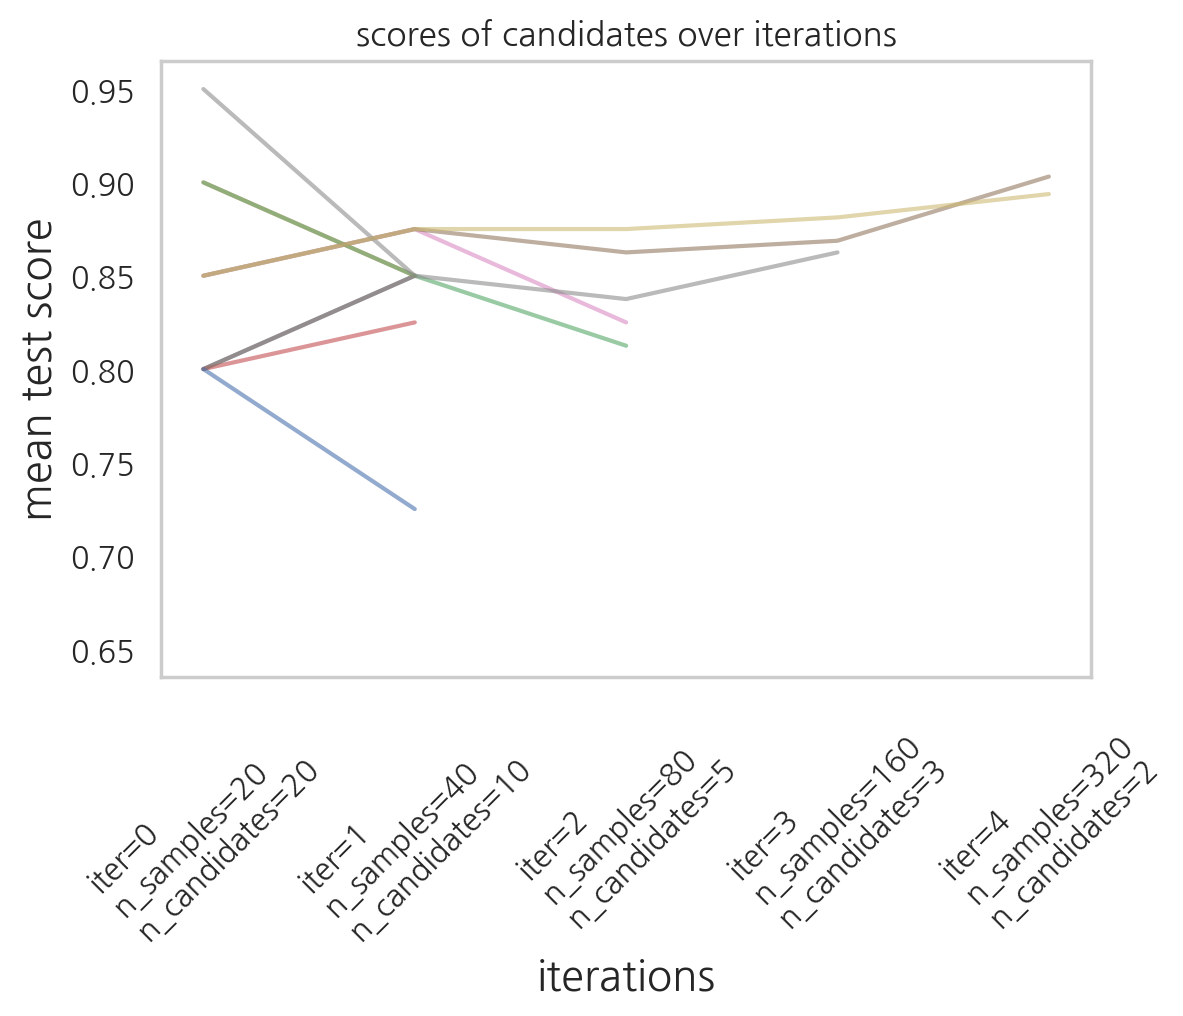

In [182]:
ax = mean_scores.plot(legend=False, alpha=0.6)
ax.set_xticks(range(h_rscv.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_xlabel("iterations", fontsize=15)
ax.set_ylabel("mean test score", fontsize=15)
ax.set_title("scores of candidates over iterations")
plt.grid(False)
plt.show() ; 

In [184]:
h_rscv.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 5,
 'min_samples_split': 4}

In [186]:
h_rscv.best_score_

0.903125

## 연습 - compare RSCV, GSCV

In [1]:
from sklearn.datasets import load_digits

In [2]:
X, y = load_digits(return_X_y=True)

X.shape, y.shape

((1797, 64), (1797,))

In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from scipy import stats

In [20]:
def cv_result_repo(cv_result, n_tops=3) : 
    
    for i in range(1, n_tops+1) : 
        candidates = np.flatnonzero(cv_result["rank_test_score"]==i)
        for candidate in candidates : 
            rank = cv_result["rank_test_score"][candidate]
            mean_scores = cv_result["mean_test_score"][candidate]
            std_scores = cv_result["std_test_score"][candidate]
            params = cv_result["params"][candidate]
            
            print("=== RSCV Rank {} model ===".format(rank))
            print("mean test score : {0:.3f}".format(mean_scores))
            print("std test score : {0:.3f}".format(std_scores))
            print("params : {}".format(params))

In [7]:
[v for v in dir(stats) if "expon" in v]

['expon', 'exponnorm', 'exponpow', 'exponweib', 'genexpon', 'truncexpon']

In [5]:
import time

In [10]:
clf = SGDClassifier(loss="hinge")
param_dist = {
    "alpha": stats.expon(scale=1),
    "penalty": ["elasticnet"],
    "l1_ratio": np.linspace(0.0, 1.0, 5)
}
start = time.time()
rscv = RandomizedSearchCV(estimator=clf, 
                          param_distributions=param_dist,
                          scoring="accuracy",
                          cv=5)
rscv.fit(X, y)

print("RSCV fitting time : {}".format(time.time() - start))

RSCV fitting time : 11.835718393325806


In [21]:
cv_result_repo(rscv.cv_results_)

=== RSCV Rank 1 model ===
mean test score : 0.923
std test score : 0.029
params : {'alpha': 2.283553901145563, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
=== RSCV Rank 2 model ===
mean test score : 0.876
std test score : 0.037
params : {'alpha': 0.2154476836133088, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
=== RSCV Rank 3 model ===
mean test score : 0.855
std test score : 0.032
params : {'alpha': 0.7822573722493438, 'l1_ratio': 0.25, 'penalty': 'elasticnet'}


In [22]:
param_grid = {
    "alpha": [0.01, 0.1, 1, 10],
    "penalty": ["elasticnet"],
    "l1_ratio": np.linspace(0.0, 1.0, 5)
}

start = time.time()
gscv = GridSearchCV(estimator=clf, 
                    param_grid=param_grid,
                    scoring="accuracy",
                    cv=5)
gscv.fit(X, y)

print("GSCV fitting time : {}".format(time.time() - start))

GSCV fitting time : 21.60181999206543


In [23]:
cv_result_repo(gscv.cv_results_)

=== RSCV Rank 1 model ===
mean test score : 0.928
std test score : 0.029
params : {'alpha': 0.1, 'l1_ratio': 0.25, 'penalty': 'elasticnet'}
=== RSCV Rank 2 model ===
mean test score : 0.922
std test score : 0.034
params : {'alpha': 1, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
=== RSCV Rank 3 model ===
mean test score : 0.915
std test score : 0.022
params : {'alpha': 0.1, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}


In [29]:
print("RSCV의 모델 후보 수 : {}".format(len(rscv.cv_results_["params"])))
print("GSCV의 모델 후보 수 : {}".format(len(gscv.cv_results_["params"])))

RSCV의 모델 후보 수 : 10
GSCV의 모델 후보 수 : 20


## 연습 - Halving RSCV

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [65]:
rng = np.random.RandomState(0)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
param_dist = {
    "max_depth": [d for d in range(3, 10, 2)],
    "max_features": stats.randint(1, 6), # 1~6 의 램덤 정수 선택
    "min_samples_split": stats.randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}


start = time.time()
hrscv = HalvingRandomSearchCV(estimator=rf,
                              param_distributions=param_dist,
                              scoring="accuracy",
                              factor=3,
                              cv=5,
                              random_state=rng)

hrscv.fit(X, y)
print("RF-HalvingRSCV fitting time : {}".format(time.time() - start))

RF-HalvingRSCV fitting time : 8.132433414459229


In [66]:
cv_result_repo(hrscv.cv_results_, n_tops=3)

=== RSCV Rank 1 model ===
mean test score : 0.930
std test score : 0.013
params : {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 4, 'min_samples_split': 4}
=== RSCV Rank 2 model ===
mean test score : 0.916
std test score : 0.019
params : {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_split': 6}
=== RSCV Rank 3 model ===
mean test score : 0.876
std test score : 0.066
params : {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 4, 'min_samples_split': 4}


In [67]:
hrscv.n_iterations_

3

In [68]:
hrscv.n_candidates_

[17, 6, 2]

In [69]:
hrscv.n_resources_

[100, 300, 900]

In [45]:
%matplotlib inline

In [70]:
result_df = pd.DataFrame(hrscv.cv_results_).sort_values("rank_test_score")
result_df.head()

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
24,2,900,0.094394,0.002930,0.005200,0.000401,False,entropy,7,4,...,0.929795,0.013311,1,0.998609,1.000000,1.0,0.998611,1.0,0.999444,0.000681
23,2,900,0.084208,0.000971,0.005799,0.000745,False,gini,7,5,...,0.916418,0.019497,2,0.998609,0.997218,1.0,0.998611,1.0,0.998888,0.001041
19,1,300,0.062799,0.000976,0.004806,0.000399,False,entropy,7,4,...,0.875763,0.065608,3,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.000000
22,1,300,0.056800,0.000977,0.004805,0.000754,False,gini,7,5,...,0.872203,0.065113,4,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.000000
21,1,300,0.054800,0.000399,0.004402,0.000490,False,entropy,9,2,...,0.858757,0.053652,5,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.000000


In [73]:
del result_df["param_str"]

In [74]:
result_df["params_str"] = result_df["params"].apply(str)
result_df["params_str"]

24    {'bootstrap': False, 'criterion': 'entropy', '...
23    {'bootstrap': False, 'criterion': 'gini', 'max...
19    {'bootstrap': False, 'criterion': 'entropy', '...
22    {'bootstrap': False, 'criterion': 'gini', 'max...
21    {'bootstrap': False, 'criterion': 'entropy', '...
20    {'bootstrap': False, 'criterion': 'entropy', '...
18    {'bootstrap': False, 'criterion': 'gini', 'max...
17    {'bootstrap': False, 'criterion': 'gini', 'max...
16    {'bootstrap': False, 'criterion': 'gini', 'max...
1     {'bootstrap': False, 'criterion': 'entropy', '...
13    {'bootstrap': False, 'criterion': 'entropy', '...
9     {'bootstrap': False, 'criterion': 'entropy', '...
6     {'bootstrap': False, 'criterion': 'gini', 'max...
10    {'bootstrap': False, 'criterion': 'gini', 'max...
14    {'bootstrap': True, 'criterion': 'entropy', 'm...
7     {'bootstrap': False, 'criterion': 'gini', 'max...
15    {'bootstrap': True, 'criterion': 'entropy', 'm...
5     {'bootstrap': False, 'criterion': 'gini', 

In [78]:
result_df.drop_duplicates(["params_str", "iter"], inplace=True)
mean_scores_pivot = result_df.pivot(
    index="iter", columns="params_str", values="mean_test_score")
mean_scores_pivot

params_str,"{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_split': 10}","{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 6}","{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 4, 'min_samples_split': 4}","{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 1, 'min_samples_split': 6}","{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 2, 'min_samples_split': 5}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_split': 10}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 4, 'min_samples_split': 5}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 1, 'min_samples_split': 2}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_split': 6}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 9, 'max_features': 1, 'min_samples_split': 3}","{'bootstrap': False, 'criterion': 'gini', 'max_depth': 9, 'max_features': 1, 'min_samples_split': 4}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 5}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 6}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_split': 6}","{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 3, 'min_samples_split': 2}","{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 3}"
iter,,,,,,,,,,,,,,,,
0,0.557368,0.62,0.723684,0.631053,0.752632,0.526842,0.723684,0.711579,0.753684,0.701579,0.682105,0.6,0.558421,0.691579,0.703684,0.578421
1,NaN,NaN,0.875763,NaN,0.858757,NaN,0.852034,0.851977,0.872203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.929795,NaN,NaN,NaN,NaN,NaN,0.916418,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
labels = ["n_iter={}\nn_samples={}\nn_cadidates={}"\
          .format(i, hrscv.n_resources_[i], hrscv.n_candidates_[i]) 
          for i in range(hrscv.n_iterations_)]
labels

['n_iter=0\nn_samples=100\nn_cadidates=17',
 'n_iter=1\nn_samples=300\nn_cadidates=6',
 'n_iter=2\nn_samples=900\nn_cadidates=2']

In [92]:
print(labels[0])

n_iter=0
n_samples=100
n_cadidates=17


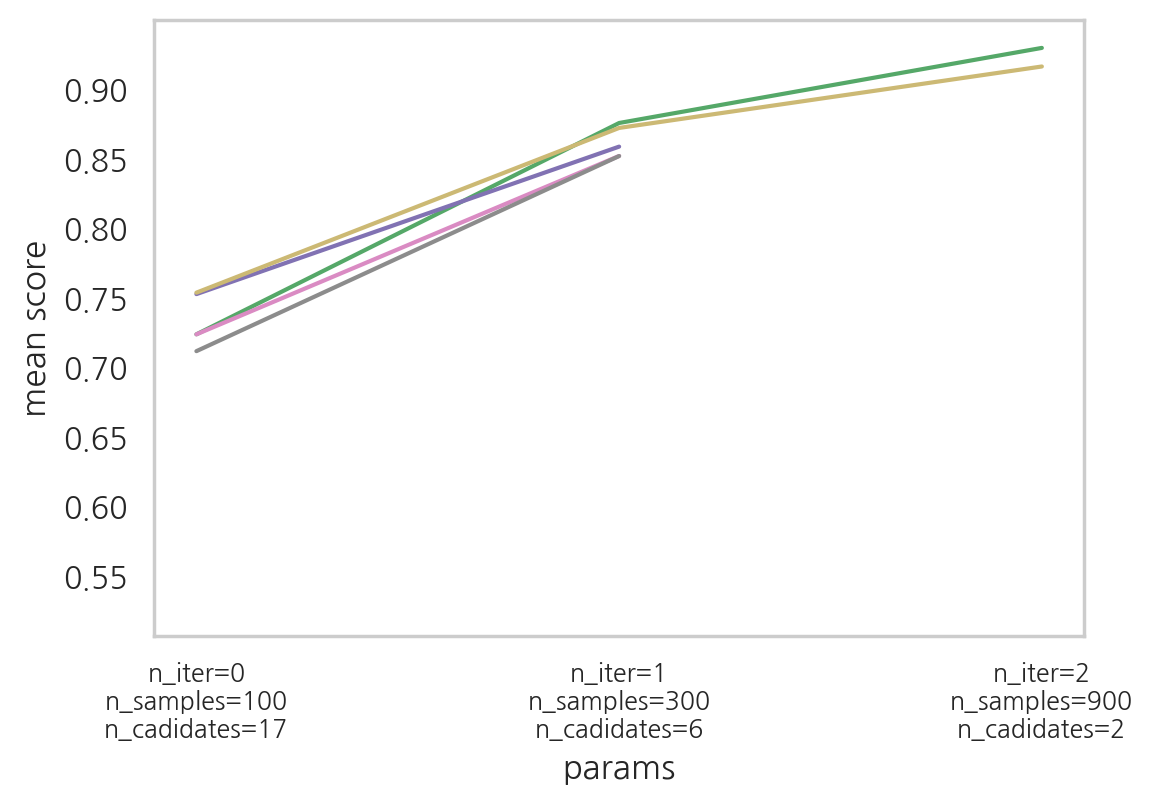

In [102]:
ax = mean_scores_pivot.plot(legend=False)
ax.set_xticks(np.arange(len(mean_scores_pivot)))
ax.set_xticklabels(labels, fontsize=9)
ax.set_xlabel("params")
ax.set_ylabel("mean score")
plt.grid(False)
plt.show() ; 

In [103]:
X.shape

(1797, 64)

In [118]:
rng = np.random.RandomState(0)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=rng)
param_dist = {
    "max_depth": [d for d in range(2, 5)],
    "min_samples_split": stats.randint(1, 6),
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False]
}

start = time.time()
h_rscv = HalvingRandomSearchCV(estimator=rf_clf,
                               param_distributions=param_dist,
                               factor=2,
                               scoring="accuracy",
                               cv=5)
h_rscv.fit(X, y)
print("fitting time : {}".format(time.time() - start))

fitting time : 22.14339327812195


In [121]:
print("best score : {}".format(h_rscv.best_score_))

best score : 0.8735325235109718


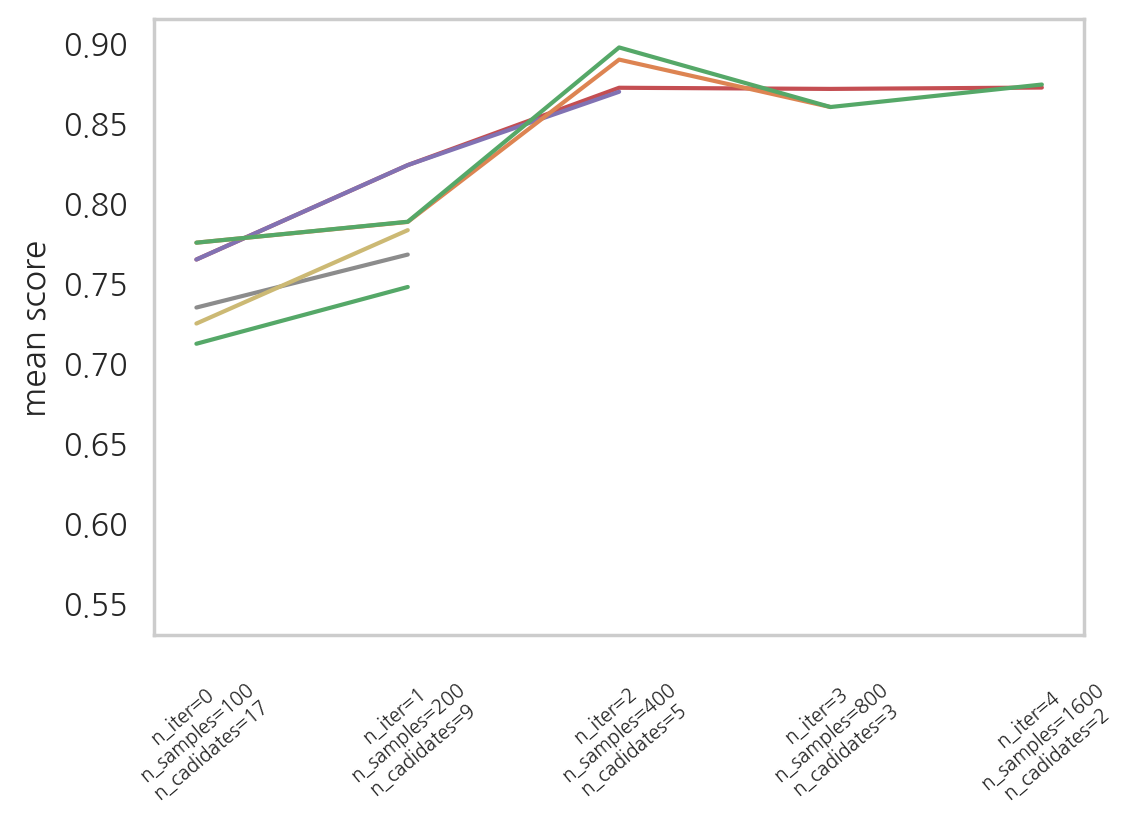

In [119]:
result_df = pd.DataFrame(h_rscv.cv_results_).sort_values("rank_test_score")
result_df["params_str"] = result_df.params.apply(str)
result_df.drop_duplicates(["params_str", "iter"], inplace=True)

mean_score_pivot = result_df.pivot(
    index="iter", columns="params_str", values="mean_test_score")

labels = ["n_iter={}\nn_samples={}\nn_cadidates={}"\
          .format(i, h_rscv.n_resources_[i], h_rscv.n_candidates_[i]) 
          for i in range(h_rscv.n_iterations_)]

ax = mean_score_pivot.plot(legend=False)
ax.set_xticks(np.arange(len(mean_score_pivot)))
ax.set_xticklabels(labels, fontsize=7, rotation=40)
ax.set_xlabel("")
ax.set_ylabel("mean score")
plt.grid(False)
plt.show() ; 